Although the flux looks good, the method is wrong. I should copy the method from 1D. And adapt it to cylindrical geometries.

In [2]:
import numpy as np
import numpy.linalg as la
from scipy.sparse import diags
import matplotlib.pyplot as plt

def get_xs(base):
    inFile = base + 'DIFFCOEF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    D = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'REMXS.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    sr = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'SP0.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    # sigmaS21, sigmaS12
    ss = float(lines[0][3]), float(lines[0][2])

    inFile = base + 'CHIT.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    chi = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'NSF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    nusf = float(lines[0][1]), float(lines[0][2])
    
    return D, sr, ss, chi, nusf

# 1D-r

$0 = D_1 (\frac{\partial^2}{\partial r^2} \phi_1 + \frac{1}{r}\frac{\partial}{\partial r}\phi_1) - \Sigma_1^r \phi_1 + \Sigma_{21}^s \phi_2 + \nu\Sigma^f_1 \phi_1 + \nu\Sigma^f_2 \phi_2$

$0 = D_2 (\frac{\partial^2}{\partial r^2} \phi_2 + \frac{1}{r}\frac{\partial}{\partial r}\phi_2) - \Sigma_2^r \phi_2 + \Sigma_{12}^s \phi_1$

Finite differences: 
* inner points: i != 0 and i != N:

$0 = D_1 (\frac{\phi_{1,i-1}-2\phi_{1,i}+\phi_{1,i+1}}{h^2} + \frac{-\phi_{1,i-1}+\phi_{1,i+1}}{2i h^2}) - \Sigma^r_{1,i} \phi_{1,i} + \Sigma^s_{21,i} \phi_{2,i} + \nu\Sigma^f_{1,i} \phi_{1,i} + \nu\Sigma^f_{2,i} \phi_{2,i}$

$0 = D_2 (\frac{\phi_{2,i-1}-2\phi_{2,i}+\phi_{2,i+1}}{h^2} + \frac{-\phi_{2,i-1}+\phi_{2,i+1}}{2i h^2}) - \Sigma^r_{2,i} \phi_{2,i} + \Sigma^s_{12,i} \phi_{1,i}$

* i = 0:

$0 = D_1 (4\frac{\phi_{1,1}-\phi_{1,0}}{h^2}) - \Sigma^r_{1,0} \phi_{1,0} + \Sigma^s_{21,0} \phi_{2,0} + \nu\Sigma^f_{1,0} \phi_{1,0} + \nu\Sigma^f_{2,0} \phi_{2,0}$

$0 = D_2 (4\frac{\phi_{2,1}-\phi_{2,0}}{h^2}) - \Sigma^r_{2,0} \phi_{2,0} + \Sigma^s_{12,0} \phi_{1,0}$


In [4]:
base = '../xs/8/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')
iD, isr, iss, ichi, inusf = get_xs(base + 'irefl_')
oD, osr, oss, ochi, onusf = get_xs(base + 'orefl_')

i =  44
k =  1.3783866447436037


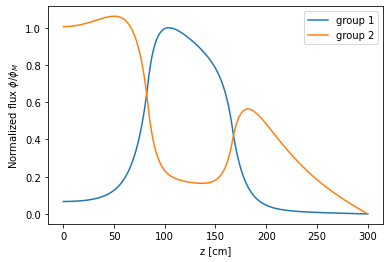

In [7]:
# Build system
N = 200
r = np.linspace(0, 300, num=N)
# priNo(x)

i = 0
while r[i] < 84: # or 86
    i += 1
Ni = i
while r[i] < 166: # or 190
    i += 1
Nc = i - Ni
No = N - Nc - Ni

h = r[1]-r[0]
h2 = h**2

# Diffusion matrix
DM = 1./h2*diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D1 = np.zeros((2*N, 2*N))

D1[:N, :N] = DM
D1[N:2*N, N:2*N] = DM

D1[:Ni] *= iD[0]
D1[Ni:Ni+Nc] *= cD[0]
D1[Ni+Nc:Ni+Nc+No] *= oD[0]

D1[N:N+Ni] *= iD[1]
D1[N+Ni:N+Ni+Nc] *= cD[1]
D1[N+Ni+Nc:N+Ni+Nc+No] *= oD[1]

DN = 1./2/h2*diags([-1, 0, 1], [-1, 0, 1], shape=(N, N)).toarray()
D2 = np.zeros((2*N, 2*N))

D2[:N, :N] = DN
D2[N:2*N, N:2*N] = DN

for i in range(1, N):
    D2[i] /= i
    D2[N+i] /= i

D2[:Ni] *= iD[0]
D2[Ni:Ni+Nc] *= cD[0]
D2[Ni+Nc:Ni+Nc+No] *= oD[0]

D2[N:N+Ni] *= iD[1]
D2[N+Ni:N+Ni+Nc] *= cD[1]
D2[N+Ni+Nc:N+Ni+Nc+No] *= oD[1]

D = D1 + D2

# Removal
SR = np.eye(2*N)
SR[:Ni, :Ni] *= -isr[0]
SR[Ni:Ni+Nc, Ni:Ni+Nc] *= -csr[0]
SR[Ni+Nc:Ni+Nc+No, Ni+Nc:Ni+Nc+No] *= -osr[0]
SR[N:N+Ni, N:N+Ni] *= -isr[1]
SR[N+Ni:N+Ni+Nc, N+Ni:N+Ni+Nc] *= -csr[1]
SR[N+Ni+Nc:N+Ni+Nc+No, N+Ni+Nc:N+Ni+Nc+No] *= -osr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
SS[:Ni, N:N+Ni] = iss[0] * aux1[:Ni, :Ni]
SS[Ni:Ni+Nc, N+Ni:N+Ni+Nc] = css[0] * aux1[Ni:Ni+Nc, Ni:Ni+Nc]
SS[Ni+Nc:Ni+Nc+No, N+Ni+Nc:N+Ni+Nc+No] = oss[0] * aux1[Ni+Nc:Ni+Nc+No, Ni+Nc:Ni+Nc+No]
SS[N:N+Ni, :Ni] = iss[1] * aux1[:Ni, :Ni]
SS[N+Ni:N+Ni+Nc, Ni:Ni+Nc] = css[1] * aux1[Ni:Ni+Nc, Ni:Ni+Nc]
SS[N+Ni+Nc:N+Ni+Nc+No, Ni+Nc:Ni+Nc+No] = oss[1] * aux1[Ni+Nc:Ni+Nc+No, Ni+Nc:Ni+Nc+No]

# Fission
F = np.zeros((2*N, 2*N))
F[Ni:Ni+Nc, Ni:Ni+Nc] = cnusf[0] * aux1[Ni:Ni+Nc, Ni:Ni+Nc]
F[Ni:Ni+Nc, N+Ni:N+Ni+Nc] = cnusf[1] * aux1[Ni:Ni+Nc, Ni:Ni+Nc]

# Apply BCs
D[0, 0] =  -4/h2*iD[0]
D[0, 1] =  4/h2*iD[0]

D[N, N] =  -4/h2*iD[1]
D[N, N+1] =  4/h2*iD[1]

LHS = D + SR + SS
# Homogeneous Dirichlet on i=N
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[N-1] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-10:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    #k = k_old * sum(F @ flux_new)/sum(F @ flux_old)
    kp = sum(F @ flux_new)/sum(F @ flux_old)
    #kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    #print(k)
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
#flux = flux_old/(sum(flux_old)*hx)
flux = flux_old
flux1 = flux[:N]
flux2 = flux[N:2*N]

flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

plt.plot(r, flux1, label='group 1')
plt.plot(r, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
# plt.savefig("1D-fuel-reflec-eig-FDM", dpi=300, bbox_inches="tight")
plt.show()